Compute and plot TC tracks and basic strength metrics.

In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS, WANDB_PROJECT
from utils import wandb_to_beaker_result
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from io import StringIO
import pandas as pd
plt.rcParams['figure.dpi'] = 200
from typing import Sequence
import os
import beaker
import subprocess
import datetime
xr.set_options(keep_attrs=True)

In [2]:
LOCAL_TC_DIR = 'tropical_cyclones_data'
URL_ERA5 = 'gs://vcm-ml-intermediate/2024-06-20-era5-1deg-8layer-1940-2022.zarr'
URL_SHIELD = 'gs://vcm-ml-intermediate/2024-07-24-vertically-resolved-c96-1deg-shield-amip-ensemble-dataset/ic_0001.zarr/'
# Constants
R = 287.05  # specific gas constant for dry air in J/(kg*K)
g = 9.8065  # acceleration due to gravity in m/s^2
TREF = 273.0 # reference temperature in K
variables = ['PRESsfc', 'TMP2m', 'UGRD10m', 'VGRD10m', 'air_temperature_3', 'sea_level_pressure', 'HGTsfc']

In [3]:
def load_tracks(filename) -> Sequence[pd.DataFrame]:
    def _load_single_track(lines):
        columns = ['lon_index', 'lat_index', 'lon', 'lat', 'slp', 'wind', 'zs', 'year', 'month', 'day', 'hour']
        data = StringIO('\n'.join(lines))
        df = pd.read_csv(data, sep='\t', header=None, names=columns)
        df.index = np.arange(len(df))
        return df

    with open(filename) as f:
        tracks = []
        current_track = None
        for line in f:
            if line.startswith('start'):
                if current_track is not None:
                    tracks.append(_load_single_track(current_track))
                current_track = []
            else:
                current_track.append(line)
        tracks.append(_load_single_track(current_track))
    return tracks

def plot_six(ds):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    ds.PRESsfc.plot(ax=axes[0])
    ds.TMP2m.plot(ax=axes[2])
    ds.sea_level_pressure.plot(ax=axes[1], vmin=98000, vmax=102000)
    ds.air_temperature_3.plot(ax=axes[3])
    ds.UGRD10m.plot(ax=axes[4])
    ds.VGRD10m.plot(ax=axes[5])
    fig.tight_layout()
    for ax in axes:
        ax.coastlines(linewidth=0.5, color='grey')
        ax.set_title(ds.time.values)

def sea_level_pressure(surface_pressure, surface_height, two_meter_air_temperature):
    da = surface_pressure * np.exp((g * surface_height) / (R * two_meter_air_temperature))
    da.attrs['long_name'] = 'Sea level pressure'
    da.attrs['units'] = 'Pa'
    return da

def plot_tracks(ax, tracks, title):
    plot_kwargs = dict(transform=ccrs.PlateCarree(), linewidth=0.5, color='tab:blue', alpha=0.3)
    first_point = tracks[0].iloc[0]
    last_point = tracks[-1].iloc[-1]
    start_time = datetime.datetime(int(first_point.year), int(first_point.month), int(first_point.day))
    end_time = datetime.datetime(int(last_point.year), int(last_point.month), int(last_point.day))
    n_years = (end_time - start_time).total_seconds() / (365.25 * 24 * 3600)
    tracks_per_year = len(tracks) / n_years
    ax.coastlines(linewidth=0.7)
    for track in tracks:
        track_lon = track.lon
        if max(track_lon) > 340 and min(track_lon) < 20:
            # avoid artifacts by separately plotting the parts of the track
            # on either side of the meridian
            track_lon_left = np.where(track_lon > 180, track_lon, np.nan)
            track_lon_right = np.where(track_lon < 180, track_lon, np.nan)
            track_lat_left = np.where(track_lon > 180, track.lat, np.nan)
            track_lat_right = np.where(track_lon < 180, track.lat, np.nan)
            ax.plot(track_lon_left, track_lat_left, **plot_kwargs)
            ax.plot(track_lon_right, track_lat_right, **plot_kwargs)
        else:
            ax.plot(track.lon, track.lat, **plot_kwargs)
    ax.set_title(f"{title} (n/year={tracks_per_year:.1f})", fontsize=8) #. {start_time} to {end_time}")
    ax.set_global()

def plot_track_variables(tracks):
    fig, axes = plt.subplots(2, 1)
    for i, track in enumerate(tracks):
        track['time'] = pd.to_datetime(track[['year', 'month', 'day', 'hour']])
        track = track.set_index('time')
        track = track.sort_index()
        track['wind'].plot(ax=axes[0])
        track['slp'].plot(ax=axes[1])
    axes[0].set_ylabel('Wind speed [m/s]')
    axes[0].set_title('Maximum 10m wind speed with 2° of candidate point')
    axes[0].set_xlabel('')
    axes[0].get_xaxis().set_ticks([])
    axes[1].set_ylabel('Sea level pressure [Pa]')
    axes[1].set_title('Sea level pressure at candidate point')
    axes[1].set_xlabel('')
    fig.tight_layout()

In [4]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS['10yr-segmented']
beaker_dataset_id = wandb_to_beaker_result(WANDB_PROJECT, wandb_id)
beaker_dataset_id

'01J6DP8XHCD50AAZZ0SGDG6WNR'

In [5]:
wandb_climSST_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS['10yr-climSST']
beaker_dataset_id_climSST = wandb_to_beaker_result(WANDB_PROJECT, wandb_climSST_id)
beaker_dataset_id_climSST

'01J74DE9TTJAMPVM8MVGSQMR3H'

In [6]:
client = beaker.Beaker.from_env()
files = client.dataset.ls(beaker_dataset_id)
n_segments = len({f.path.split('/')[0] for f in files})

In [7]:
surface_height = xr.open_zarr(URL_ERA5)['HGTsfc'].load()
surface_height = surface_height.rename({'latitude': 'lat', 'longitude': 'lon'})

### Download and prepare ACE2 data for TC detection

In [8]:
# download data, compute SLP and save to disk
for segment in range(n_segments):
    print(f"Processing segment {segment}")
    filename = f"segment_{segment:04}/autoregressive_predictions.nc"
    output_filename = os.path.join(LOCAL_TC_DIR, f'ACE2_ERA5_data_{segment:04}.nc')
    if not os.path.exists(output_filename):
        ! beaker dataset fetch $beaker_dataset_id --prefix $filename --output tmp_data --quiet
        ds = xr.open_dataset(f'tmp_data/{filename}')
        ds = ds.isel(sample=0)
        ds['time'] = ds.valid_time
        ds = xr.merge([ds, surface_height], compat='override', join='override')
        ds['sea_level_pressure'] = sea_level_pressure(ds.PRESsfc, ds.HGTsfc, ds.TMP2m)
        out = ds.convert_calendar('gregorian').transpose('time', 'lat', 'lon')
        out.to_netcdf(output_filename)
        ! rm 'tmp_data/{filename}'

Processing segment 0
Processing segment 1
Processing segment 2
Processing segment 3
Processing segment 4
Processing segment 5
Processing segment 6
Processing segment 7
Processing segment 8
Processing segment 9


In [9]:
# get start time and segment length
sample_ds = xr.open_dataset(os.path.join(LOCAL_TC_DIR, 'ACE2_ERA5_data_0000.nc'))
start_time = sample_ds.time.values[0]
end_time = xr.open_dataset(os.path.join(LOCAL_TC_DIR, f'ACE2_ERA5_data_{n_segments-1:04}.nc')).time.values[-1]
segment_length = sample_ds.sizes['time']

### Download data for ACE2-ERA5-climSST run

In [10]:
# download data, compute SLP and save to disk
for segment in range(n_segments):
    print(f"Processing segment {segment}")
    filename = f"segment_{segment:04}/autoregressive_predictions.nc"
    output_filename = os.path.join(LOCAL_TC_DIR, f'ACE2_ERA5_climSST_data_{segment:04}.nc')
    if not os.path.exists(output_filename):
        ! beaker dataset fetch $beaker_dataset_id_climSST --prefix $filename --output tmp_data --quiet
        ds = xr.open_dataset(f'tmp_data/{filename}', engine='netcdf4')
        ds = ds.isel(sample=0)
        ds['time'] = ds.valid_time
        ds = xr.merge([ds, surface_height], compat='override', join='override')
        ds['sea_level_pressure'] = sea_level_pressure(ds.PRESsfc, ds.HGTsfc, ds.TMP2m)
        out = ds.convert_calendar('gregorian').transpose('time', 'lat', 'lon')
        out.to_netcdf(output_filename)
        ! rm 'tmp_data/{filename}'

Processing segment 0
Processing segment 1
Processing segment 2
Processing segment 3
Processing segment 4
Processing segment 5
Processing segment 6
Processing segment 7
Processing segment 8
Processing segment 9


### Download and prepare ERA5 data for TC detection

In [11]:
def download_and_insert_slp(ds, output_prefix, n_segments, segment_length):
    for segment in range(n_segments):
        print(f"Processing segment {segment}")
        output_filename = output_prefix + f'{segment:04}.nc'
        if not os.path.exists(output_filename):
            i_start = segment * segment_length
            i_end = i_start + segment_length
            ds_segment = ds.isel(time=slice(i_start, i_end))
            ds_segment['sea_level_pressure'] = sea_level_pressure(
                ds_segment.PRESsfc, ds_segment.HGTsfc, ds_segment.TMP2m
            )
            ds_segment = ds_segment[variables]
            ds_segment.to_netcdf(output_filename)
        

In [12]:
ds = xr.open_zarr(URL_ERA5).sel(time=slice(start_time, end_time))
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
download_and_insert_slp(ds, os.path.join(LOCAL_TC_DIR, 'ERA5_data_'), n_segments, segment_length)

Processing segment 0
Processing segment 1
Processing segment 2
Processing segment 3
Processing segment 4
Processing segment 5
Processing segment 6
Processing segment 7
Processing segment 8
Processing segment 9


### Download and prepare SHiELD data for TC detection

In [13]:
ds = xr.open_zarr(URL_SHIELD).sel(time=slice(start_time, end_time))
ds = ds.rename({'grid_yt': 'lat', 'grid_xt': 'lon'})
download_and_insert_slp(ds, os.path.join(LOCAL_TC_DIR, 'SHIELD_data_'), n_segments, segment_length)


Processing segment 0
Processing segment 1
Processing segment 2
Processing segment 3
Processing segment 4
Processing segment 5
Processing segment 6
Processing segment 7
Processing segment 8
Processing segment 9


### Plot some snapshots of data

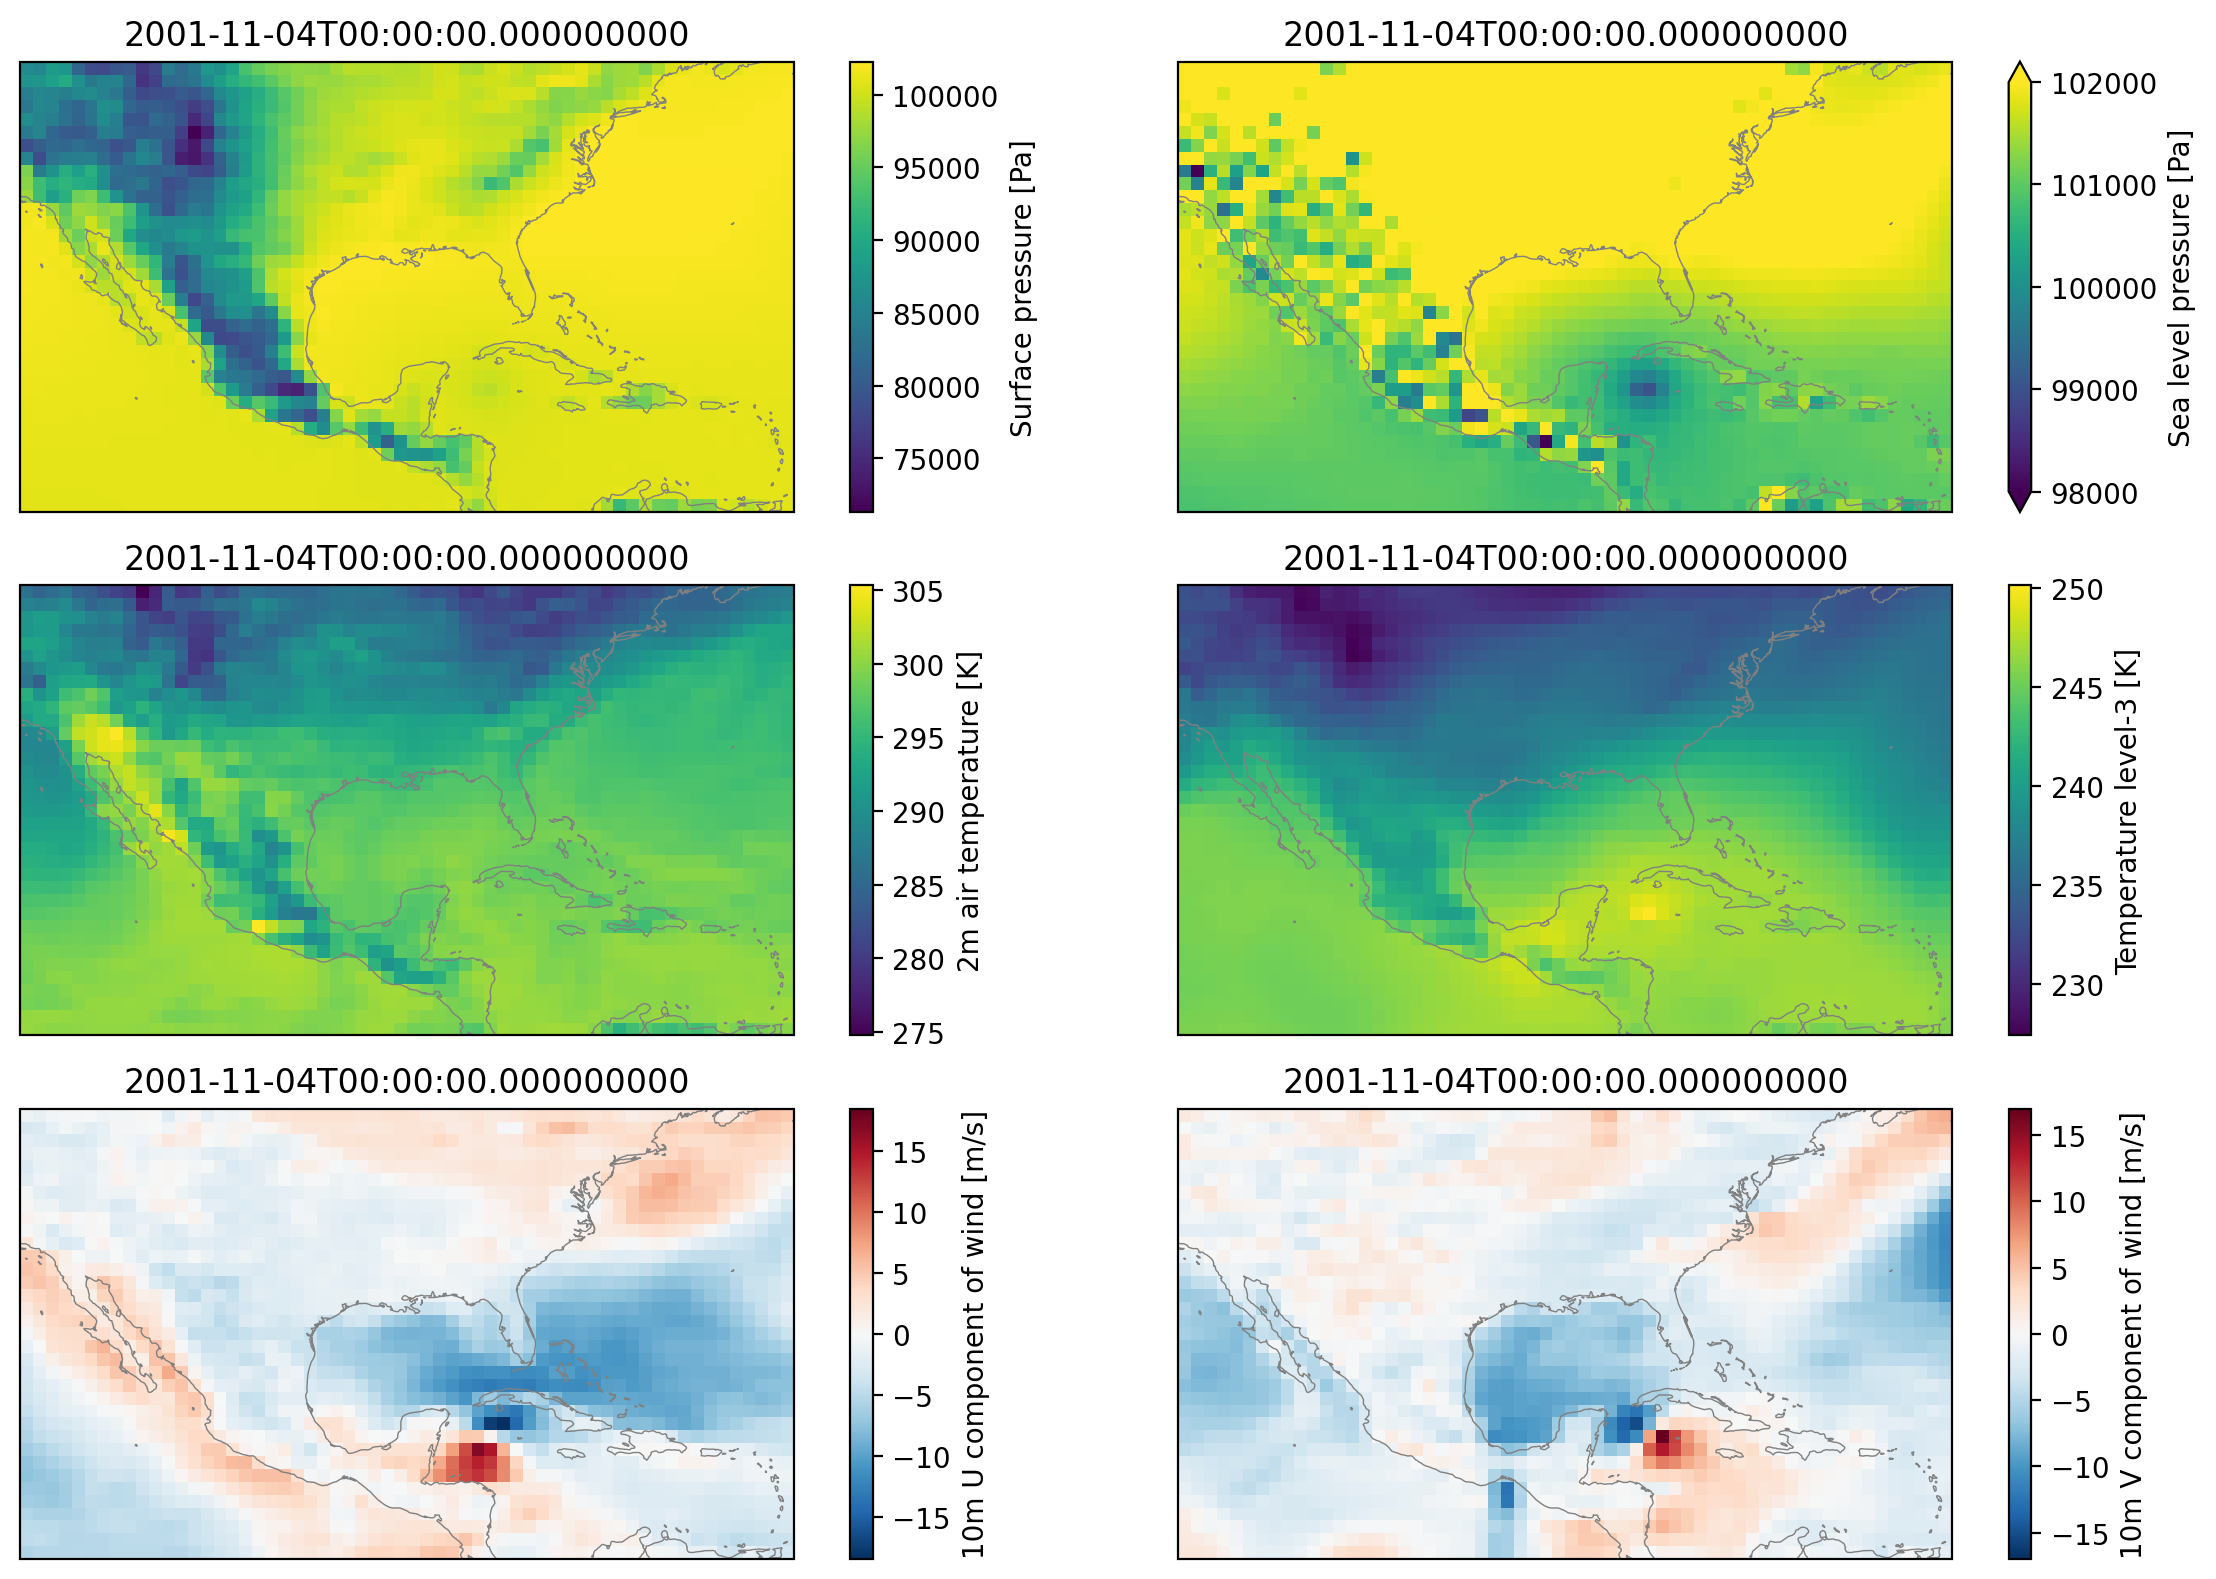

In [14]:
TIME = '2001-11-04T00:00:00'
ds = xr.open_dataset(os.path.join(LOCAL_TC_DIR, 'ERA5_data_0000.nc'))
plot_six(ds.sel(time=TIME, lat=slice(10, 45), lon=slice(240, 300)))

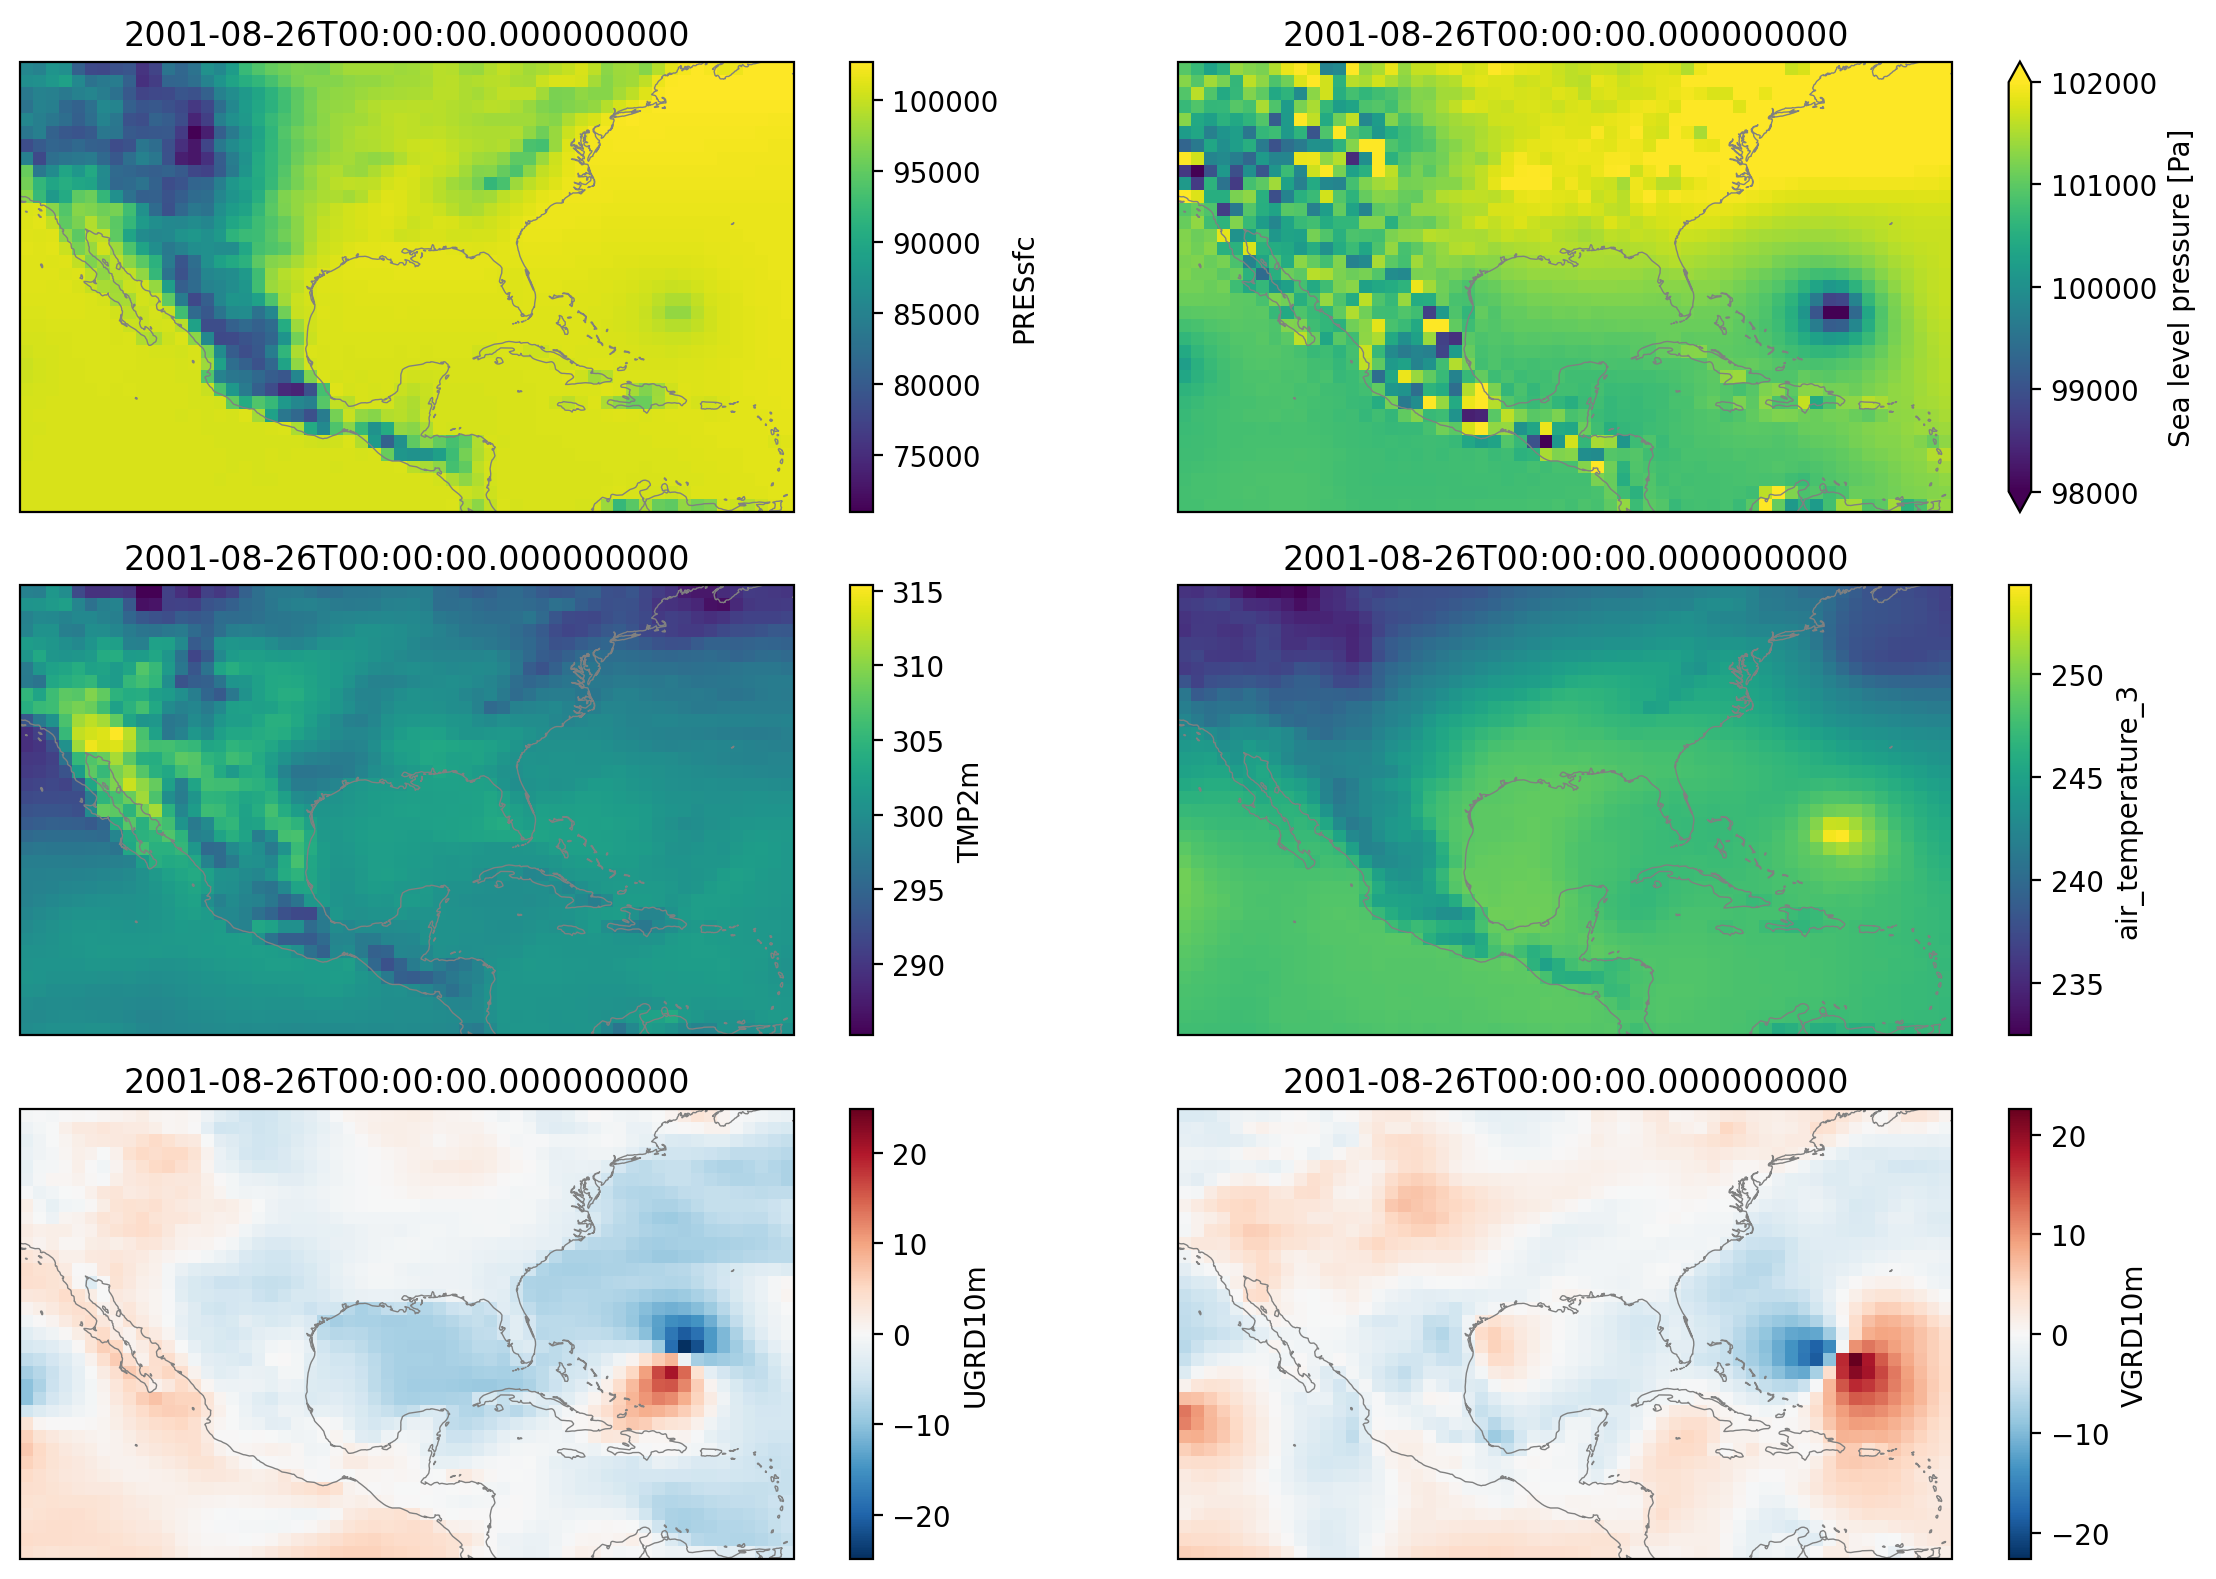

In [15]:
TIME = '2001-08-26T00:00:00'
ds = xr.open_dataset(os.path.join(LOCAL_TC_DIR, 'ACE2_ERA5_data_0000.nc'))
plot_six(ds.sel(time=TIME, lat=slice(10, 45), lon=slice(240, 300)))

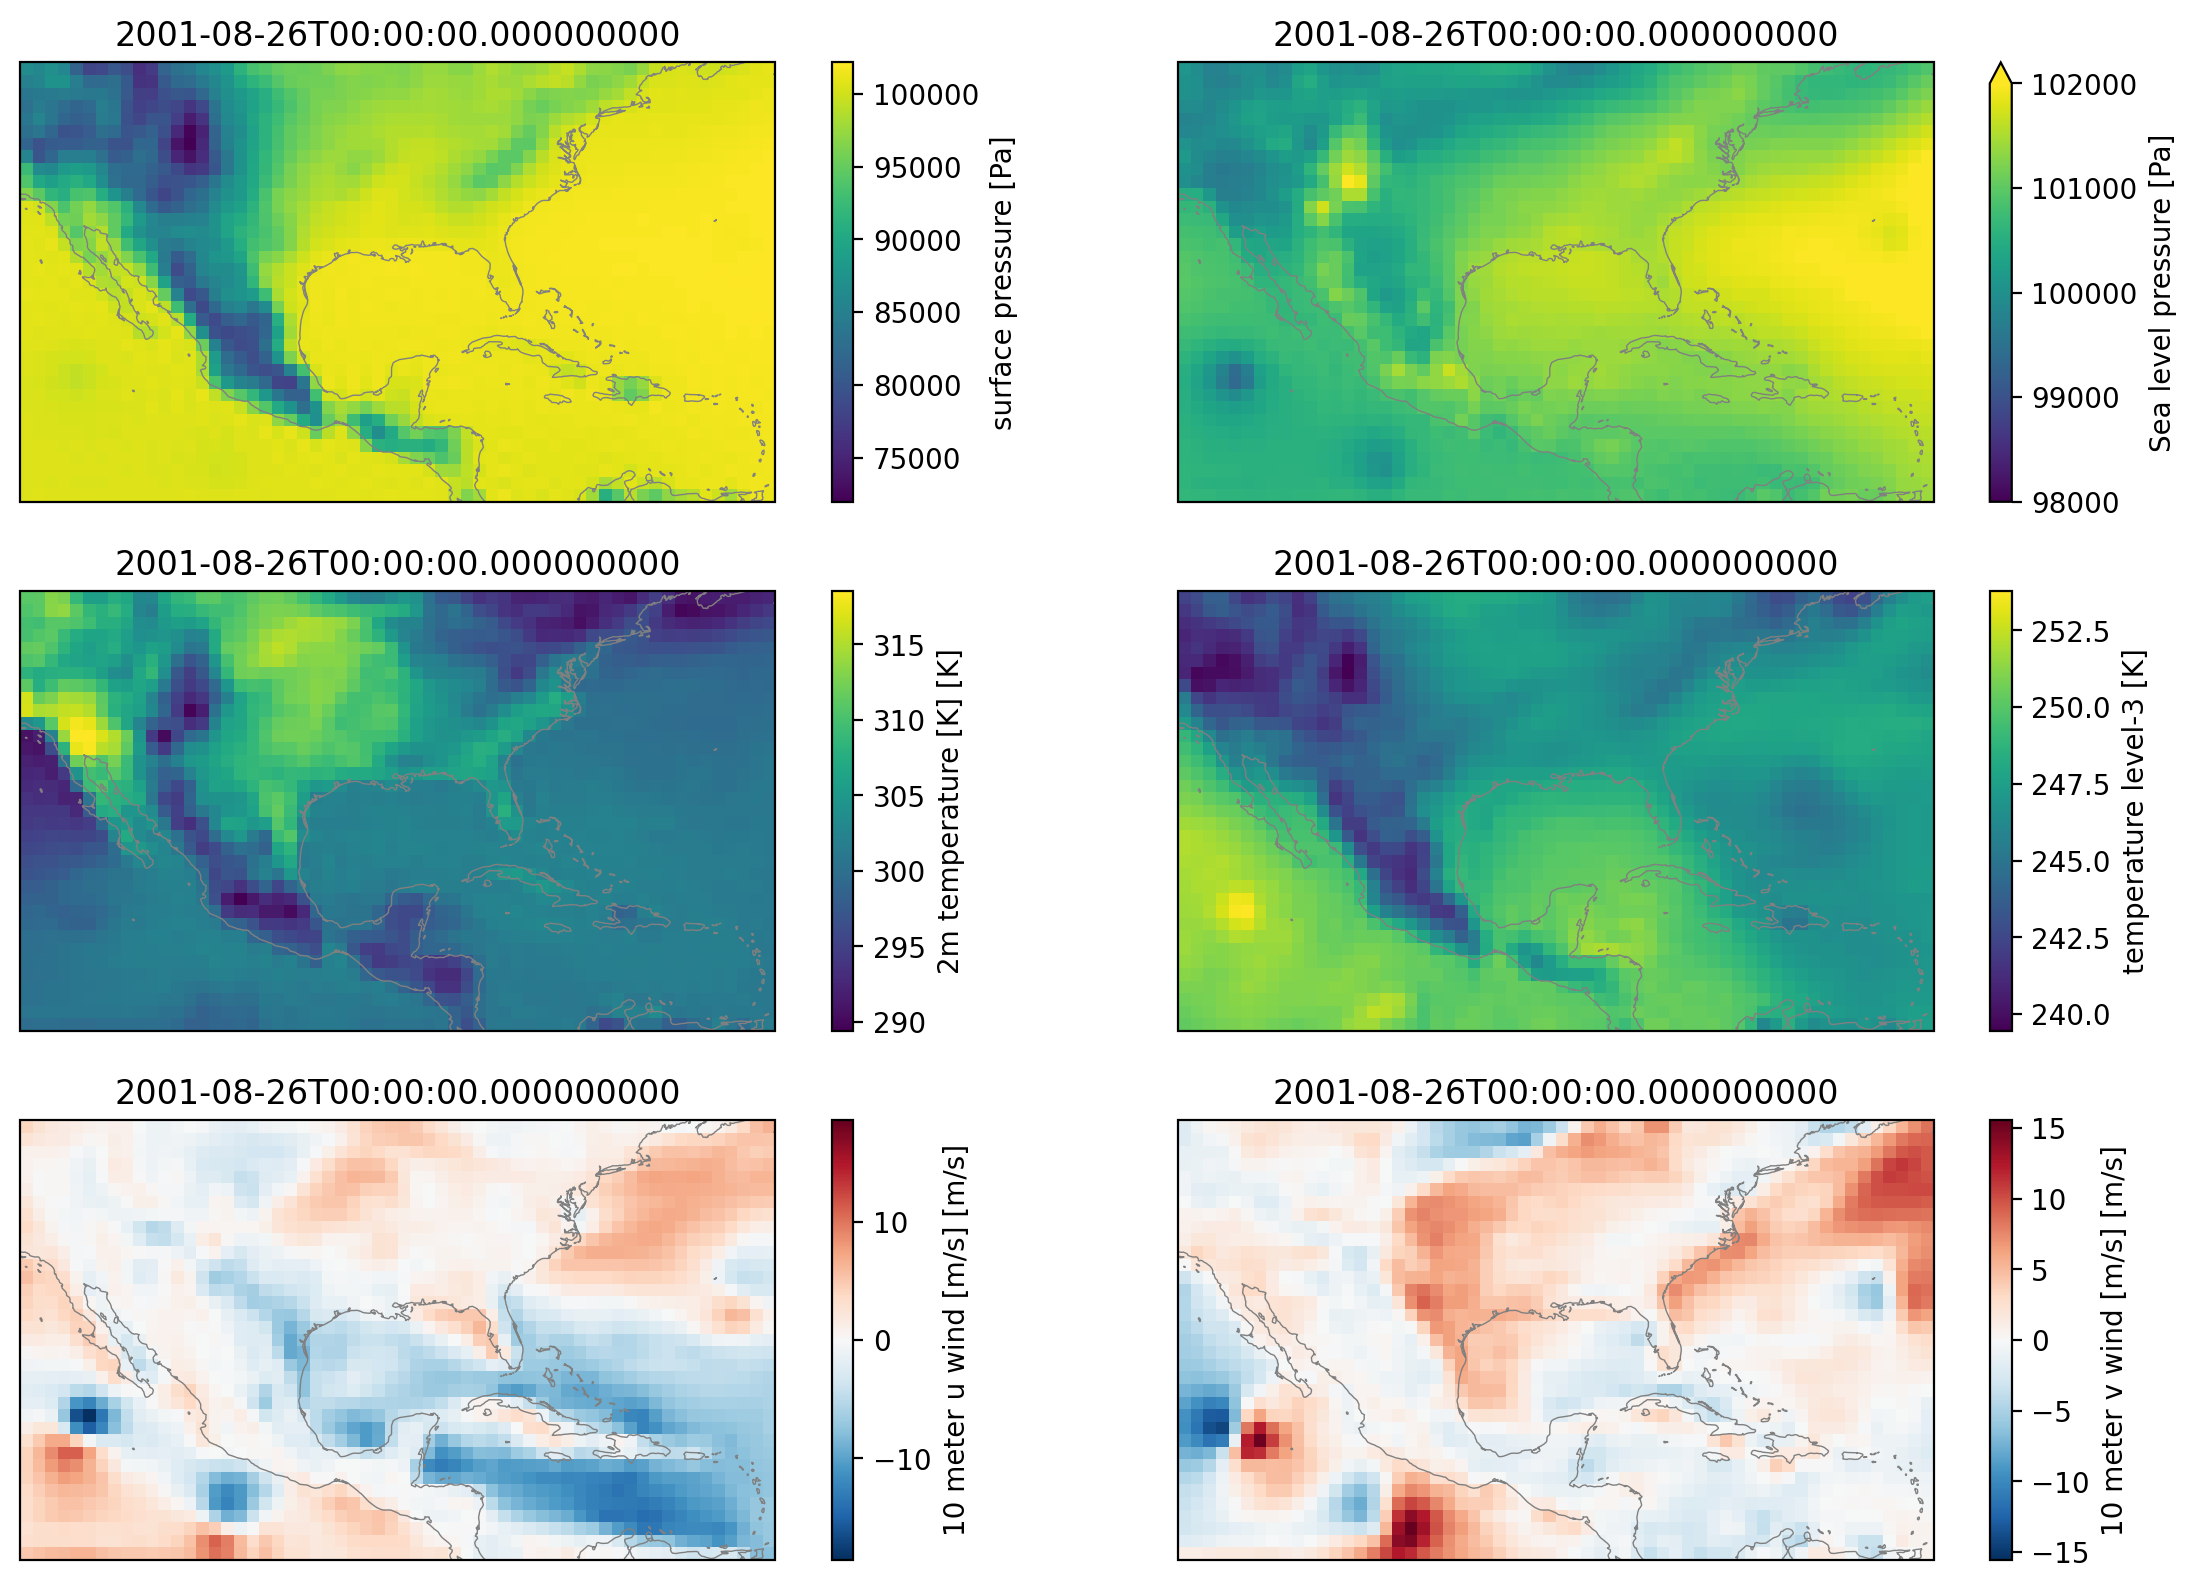

In [16]:
TIME = '2001-08-26T00:00:00'
ds = xr.open_dataset(os.path.join(LOCAL_TC_DIR, 'SHIELD_data_0000.nc'))
plot_six(ds.sel(time=TIME, lat=slice(10, 45), lon=slice(240, 300)))

### Save data to disk and run TC detection

In [17]:
def detect_nodes(
    in_data,
    out,
    searchbymin="sea_level_pressure",
    closedcontourcmd="sea_level_pressure,200.0,5.5,0;air_temperature_3,-1,6.5,1.0",
    mergedist="6.0",
    outputcmd="sea_level_pressure,min,0;_VECMAG(UGRD10m,VGRD10m),max,2;HGTsfc,min,0",
):
    """Defaults here are taken from https://gmd.copernicus.org/articles/14/5023/2021/
    except we use air_temperature_3 instead of Z300-Z500 thickness."""
    if os.path.exists(out):
        print(f"Output {out} already exists, skipping")
        return
    subprocess.check_call(
        [
            "DetectNodes",
            "--in_data",
            in_data,
            "--out",
            out,
            "--searchbymin",
            searchbymin,
            "--closedcontourcmd",
            closedcontourcmd,
            "--mergedist",
            mergedist,
            "--outputcmd",
            outputcmd,
        ],
    )

def stitch_nodes(
        in_,
        out,
        in_fmt="lon,lat,slp,wind,zs",
        range="8.0",
        mintime="54h",
        maxgap="24h",
        threshold="wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10;zs,<=,150.0,10"
    ):
    """Defaults here are taken from https://gmd.copernicus.org/articles/14/5023/2021/"""
    subprocess.check_call(
        [
            "StitchNodes",
            "--in",
            in_,
            "--out",
            out,
            "--in_fmt",
            in_fmt,
            "--range",
            range,
            "--mintime",
            mintime,
            "--maxgap",
            maxgap,
            "--threshold",
            threshold,
        ]
    )

In [18]:
def detect_and_stitch(prefix, n_segments):
    for segment in range(n_segments):
        input_path = f"{prefix}data_{segment:04}.nc"
        intermediate_path = f"{prefix}candidate_points_{segment:04}.txt"
        detect_nodes(input_path, intermediate_path)

    # concatenate all text files in prior for loop into one using python
    all_candidates = f'{prefix}candidate_points.txt'
    with open(all_candidates, 'w') as outfile:
        for segment in range(n_segments):
            intermediate_path = f"{prefix}candidate_points_{segment:04}.txt"
            with open(intermediate_path) as infile:
                outfile.write(infile.read())

    stitch_nodes(
        all_candidates,
        f"{prefix}tracks.txt"
    )

In [19]:
detect_and_stitch(os.path.join(LOCAL_TC_DIR, 'ERA5_'), n_segments)

Output tropical_cyclones_data/ERA5_candidate_points_0000.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0001.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0002.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0003.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0004.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0005.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0006.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0007.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0008.txt already exists, skipping
Output tropical_cyclones_data/ERA5_candidate_points_0009.txt already exists, skipping
Arguments:
  --in <string> ["tropical_cyclones_data/ERA5_candidate_points.txt"] 
  --in_list <string> [""] 
  --in_connect <string> [""] 
  

In [20]:
detect_and_stitch(os.path.join(LOCAL_TC_DIR, 'ACE2_ERA5_'), n_segments)

Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0000.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0001.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0002.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0003.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0004.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0005.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0006.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0007.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0008.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_candidate_points_0009.txt already exists, skipping
Arguments:
  --in <string> ["tropical_cyclones_data/ACE2_ERA5_candidate_points.txt"] 
  --


..Discrete times: 14600 (2001-01-01 06:00:00 to 2010-12-30 00:00:00)
..Done
Creating KD trees at each time level.. Done
Populating set of path segments.. Done
Constructing paths
..Paths rejected (mintime): 8864
..Paths rejected (minendpointdist): 0
..Paths rejected (minpathdist): 0
..Paths rejected (threshold): 1342
..Total paths found: 454
..Done
Writing results.. Done
Cleanup.. Done
------------------------------------------------------------


In [21]:
detect_and_stitch(os.path.join(LOCAL_TC_DIR, 'SHIELD_'), n_segments)

Output tropical_cyclones_data/SHIELD_candidate_points_0000.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0001.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0002.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0003.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0004.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0005.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0006.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0007.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0008.txt already exists, skipping
Output tropical_cyclones_data/SHIELD_candidate_points_0009.txt already exists, skipping
Arguments:
  --in <string> ["tropical_cyclones_data/SHIELD_candidate_points.txt"] 
  --in_list <string> [""] 
  --in_con

In [22]:
detect_and_stitch(os.path.join(LOCAL_TC_DIR, 'ACE2_ERA5_climSST_'), n_segments)

Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0000.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0001.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0002.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0003.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0004.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0005.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0006.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0007.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0008.txt already exists, skipping
Output tropical_cyclones_data/ACE2_ERA5_climSST_candidate_points_0009.txt already exists, skipping
Arguments:

### Load computed tracks and make some plots

In [23]:
tracks_era5 = load_tracks(os.path.join(LOCAL_TC_DIR, 'ERA5_tracks.txt'))
tracks_ace2_era5 = load_tracks(os.path.join(LOCAL_TC_DIR, 'ACE2_ERA5_tracks.txt'))
tracks_ace2_era5_climSST = load_tracks(os.path.join(LOCAL_TC_DIR, 'ACE2_ERA5_climSST_tracks.txt'))
tracks_shield = load_tracks(os.path.join(LOCAL_TC_DIR, 'SHIELD_tracks.txt'))

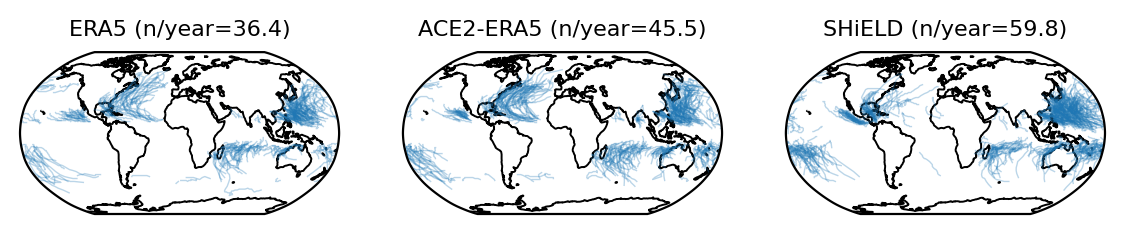

In [24]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Robinson()}, figsize=(7, 4.5))
axes = axes.flatten()
plot_tracks(axes[0], tracks_era5, f"ERA5")
plot_tracks(axes[1], tracks_ace2_era5, f"ACE2-ERA5")
plot_tracks(axes[2], tracks_shield, f"SHiELD")
fig.savefig('figures/era5_ace2_shield_TC_tracks.png', dpi=300, transparent=True)

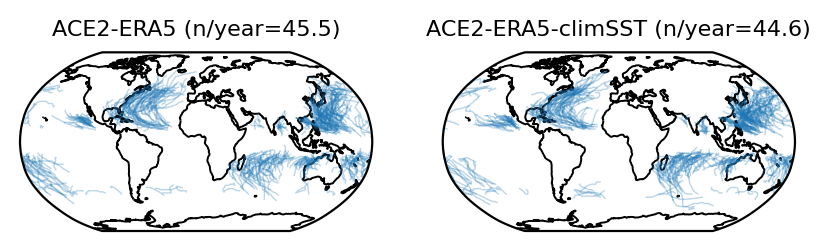

In [25]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson()}, figsize=(5, 4.5))
axes = axes.flatten()
plot_tracks(axes[0], tracks_ace2_era5, f"ACE2-ERA5")
plot_tracks(axes[1], tracks_ace2_era5_climSST, f"ACE2-ERA5-climSST")
fig.savefig('figures/era5_ace2_vs_clim_TC_tracks.png', dpi=300, transparent=True)

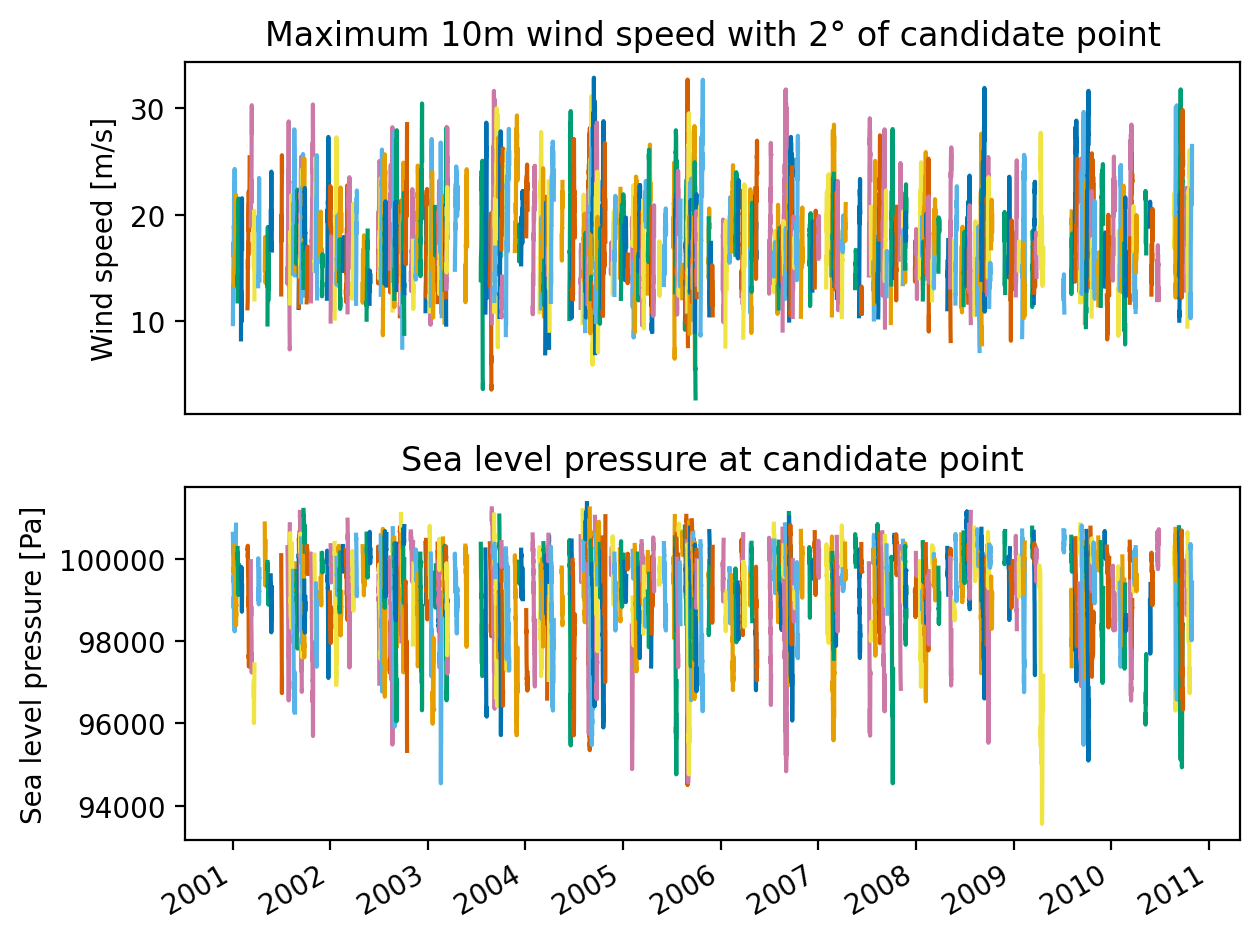

In [26]:
plot_track_variables(tracks_era5)

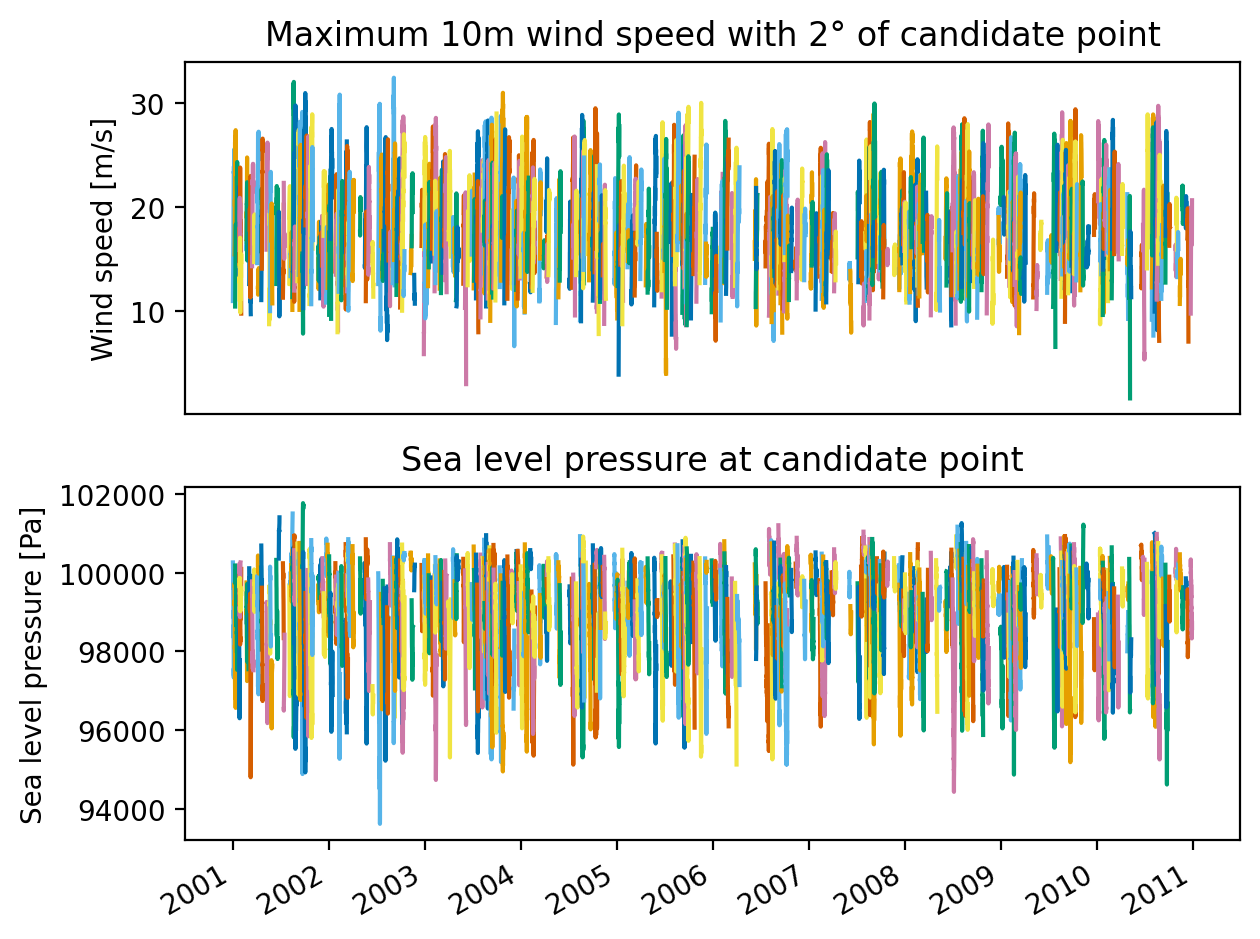

In [27]:
plot_track_variables(tracks_ace2_era5)

In [28]:
duration_days_era5 = [len(track)/4.0 for track in tracks_era5]
duration_days_ace2_era5 = [len(track)/4.0 for track in tracks_ace2_era5]
print(np.mean(duration_days_era5), np.mean(duration_days_ace2_era5))

5.580307262569832 5.779735682819383


In [29]:
min_slp_era5 = [track.slp.min()/100 for track in tracks_era5]
min_slp_ace2_era5 = [track.slp.min()/100 for track in tracks_ace2_era5]
min_slp_shield = [track.slp.min()/100 for track in tracks_shield]

max_windspeed_era5 = [track.wind.max() for track in tracks_era5]
max_windspeed_ace2_era5 = [track.wind.max() for track in tracks_ace2_era5]

max_windspeed_shield = [track.wind.max() for track in tracks_shield]

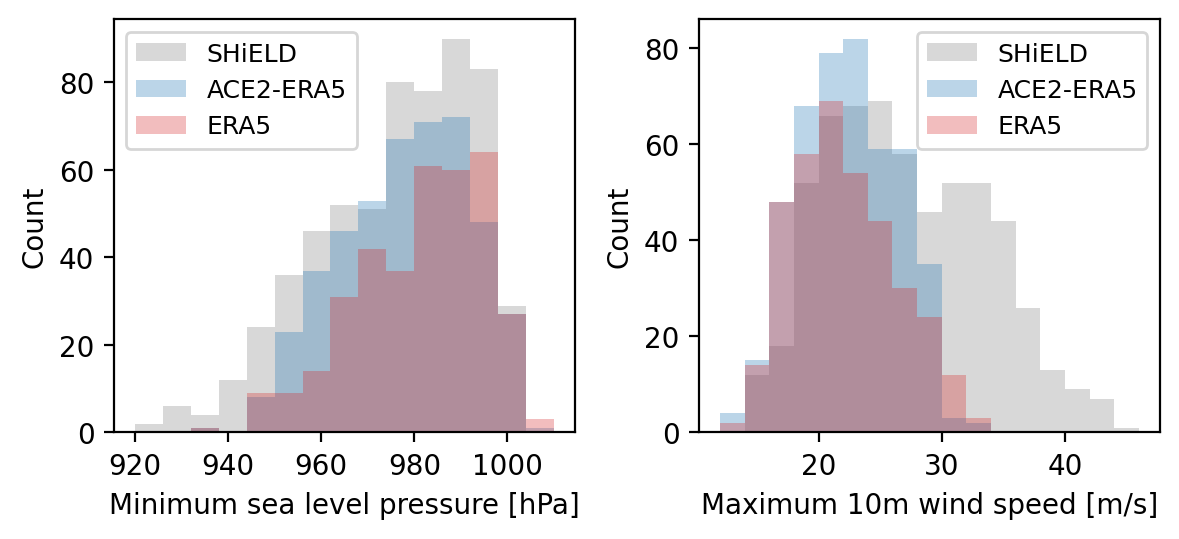

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.8))
data = [min_slp_era5, min_slp_ace2_era5, min_slp_shield]
labels = ['ERA5', 'ACE2-ERA5', 'SHiELD']
colors = ['tab:red', 'tab:blue', 'tab:gray']
axes[0].hist(data, bins=range(920, 1015, 6), label=labels, histtype='stepfilled', alpha=0.3, color=colors)

data = [max_windspeed_era5, max_windspeed_ace2_era5, max_windspeed_shield]
axes[1].hist(data, bins=range(12, 47, 2), label=labels, histtype='stepfilled', alpha=0.3, color=colors)

axes[0].legend(fontsize=9)
axes[0].set_xlabel('Minimum sea level pressure [hPa]')
axes[0].set_ylabel('Count')
axes[1].legend(fontsize=9)
axes[1].set_xlabel('Maximum 10m wind speed [m/s]')
axes[1].set_ylabel('Count')
fig.tight_layout()
fig.savefig('figures/era5_ace2_shield_TC_stats.png', dpi=300, transparent=True)